In [1]:
# Imports
from sklearn.feature_extraction.text import *
from sklearn.linear_model import *
from sklearn.naive_bayes import *
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import *
from sklearn.svm import *
from sklearn.calibration import *
from sklearn.utils.validation import check_is_fitted
from sklearn.discriminant_analysis import *
from sklearn.gaussian_process import *
from sklearn.mixture import *
from sklearn.neighbors import *
from sklearn.neural_network import *
from sklearn.semi_supervised import *
from sklearn.tree import *
from pathlib import Path
from pandas import read_csv, DataFrame, MultiIndex, merge
from aenum import extend_enum
from enum import Enum, unique
from collections import OrderedDict
from concurrent.futures import ProcessPoolExecutor, as_completed
from multiprocessing import cpu_count
from itertools import chain, combinations
from pathlib import Path
from os import mkdir
import matplotlib.pyplot as plt
import inspect

In [2]:
# Stores the different vectorizers
class Vectorizers(Enum):
    Tfidf = TfidfVectorizer()
    Unigram = CountVectorizer()
    Bigram = CountVectorizer(ngram_range = (2,2))
    Trigram = CountVectorizer(ngram_range = (3,3))
    Uni_and_Bigram = CountVectorizer(ngram_range = (1,2))

In [3]:
# Utility functions for models
@unique
class ModelUtils(Enum): 
    # Returns all models in a list 
    @classmethod
    def list(self):
        return list(map(lambda x: x.value, self))
    
    # Returns all models in a list 
    @classmethod
    def list(self):
        return list(map(lambda x: x.value, self))
    
    # Fits all models to some given data
    @classmethod
    def fit(self, Xtrain, Ytrain):
        if not len(self.list()):
            futures = []
            with ProcessPoolExecutor() as executor:
                for x in Models:
                    future = executor.submit(x.value.fit, Xtrain, Ytrain)
                    futures.append(future)
                for i, x in enumerate(as_completed(futures)):
                    print('Model {:>2} of {} has been fitted'.format(i + 1, len(futures)))
                executor.shutdown
            print()
            for x, y in zip(futures, Models):
                extend_enum(self, y.name, x.result())

In [4]:
# Represents the text data matrix
class TextTransform:
    # Object initalization
    # Args   : datafile  : A filename that contains raw data
    #        : vectorizer: The type of vectorizer to create the matrix
    # Returns: The Data object
    def __init__(self, datafile, vectorizer):
        self.Raw = datafile
        self.Vectorizer = vectorizer
        
    # Stores the matrix for a given vectorizer
    @property
    def Matrix(self):
        if not hasattr(self, '__matrix'):
            matrix = OrderedDict()
            matrix['X'] = self.Vectorizer.fit_transform(self.Raw.X)
            matrix['Y'] = self.Raw.Y
            self.__matrix = matrix
        return self.__matrix
        
    # Stores the vectorizer to use
    @property
    def Vectorizer(self):
        return self.__vectorizer
    
    @Vectorizer.setter
    def Vectorizer(self, vectorizer):
        if not hasattr(self, '__vectorizer'):
            self.__vectorizer = vectorizer
    
    # Stores the dataframe with the raw data
    @property
    def Raw(self):
        return self.__raw
    
    @Raw.setter
    def Raw(self, datafile):
        data = read_csv(datafile) 
        if data.shape[1] != 2:
            raise ValueError('Your raw datafile must have 2 columns.')
        data.columns = ['X', 'Y']
        self.__raw = data

In [10]:
# Stores the data matricies
class Data:
    # Object initalization
    # Args   : datafile: A filename that contains raw data
    # Returns: The Data object
    def __init__(self, datafile):
        self.Datafile = datafile
        
    # Stores the filename of the datafile
    @property
    def Datafile(self):
        return self.__datafile
    
    @Datafile.setter
    def Datafile(self, datafile):
        self.__datafile = datafile
        
    # Stores the vectorized count matrix of a unigram data model
    @property
    def UnigramMatrix(self):
        if not hasattr(self, '__unigramMatrix'):
            self.__unigramMatrix = TextTransform(self.Datafile, Vectorizers.Unigram.value).Matrix
        return {'Unigram': self.__unigramMatrix}
    
    # Stores the vectorized count matrix of a bigram data model
    @property
    def BigramMatrix(self):
        if not hasattr(self, '__bigramMatrix'):
            self.__bigramMatrix = TextTransform(self.Datafile, Vectorizers.Bigram.value).Matrix
        return {'Bigram': self.__bigramMatrix}
    
    # Stores the vectorized td-idf matrix
    @property
    def TfidfMatrix(self):
        if not hasattr(self, '__tfidfMatrix'):
            self.__tfidfMatrix = TextTransform(self.Datafile, Vectorizers.Tfidf.value).Matrix
        return {'Tfidf': self.__tfidfMatrix}
    
    # Stores the vectorized count matrix of a trigram data model
    @property
    def TrigramMatrix(self):
        if not hasattr(self, '__trigramMatrix'):
            self.__trigramMatrix = TextTransform(self.Datafile, Vectorizers.Trigram.value).Matrix
        return {'Trigram': self.__trigramMatrix}
    
    # Stores the vectorized count matrix of a trigram data model
    @property
    def Uni_and_BigramMatrix(self):
        if not hasattr(self, '__uniBiMatrix'):
            self.__uniBiMatrix = TextTransform(self.Datafile, Vectorizers.Uni_and_Bigram.value).Matrix
        return {'Uni_and_Bigram': self.__uniBiMatrix}

In [6]:
# CFA class for CFA analysis
class CFA:
    # Object initalization
    # Args   : features: The features to perform CFA
    #        : data: The data to use for 
    # Returns: The CFA object
    def __init__(self, features, data, classes):
        self.Data = data
        print('Begin CFA with {} dataset.\n'.format(list(data.keys())[0]))
        self.Features = features
        self.Classes = classes
        self.Scores
        self.Ranks
        self.CombinedScores
        self.CombinedRanks
        self.PrecisionScores
        print('\nEnd CFA with {} dataset.\n\n'.format(list(data.keys())[0]))
       
    # Property to return the different classes 
    @property
    def Classes(self):
        return self.__classes
    
    @Classes.setter
    def Classes(self, classes):
        self.__classes = OrderedDict(sorted(classes.items(), key = lambda x: x[1]))
        
    # Property to hold the input dataset
    @property
    def Data(self):
        return self.__data
    
    @Data.setter
    def Data(self, data):
        self.__data = list(data.items())[0]
    
    # Stores the different features to combine
    @property
    def Features(self):
        return self.__features
    
    @Features.setter
    def Features(self, features):
        features.fit(*self.TrainSet['Training set'])
        self.__features = features
    
    # Property to return the training set and initalize the test sets
    @property
    def TrainSet(self):
        if not hasattr(self, '__trainSet'):
            TrainSetX, TestSetX, TrainSetY, TestSetY = train_test_split(*self.Data[1].values(), test_size = .2, random_state = 1)
            self.__trainSet = {
                'Training set': [TrainSetX, TrainSetY], 
                'Testing set': [TestSetX, TestSetY] # This testing set is used to split into a validation set and and unknown
            }
        return self.__trainSet
    
    # Property to return the validation set and the unknown set
    @property
    def TestSets(self):
        if not hasattr(self, '__testSets'):
            TestX1, TestX2, TestY1, TestY2 = train_test_split(*self.TrainSet['Testing set'], test_size = .5, random_state = 1)
            self.__testSets = {
                'T1': [TestX1, TestY1],
                'T2': [TestX2, TestY2]
            }
        return self.__testSets
    
    # Property to record scores
    @property
    def Scores(self):
        try:
            self.__scores
            val = True
        except AttributeError as e:
            val = False
        if not val:
            scaler = MinMaxScaler()
            modelNames = [model.name for model in self.Features]
            index = ['d{}'.format(x) for x in range(1, self.TestSets['T1'][0].shape[0] + 1)]
            cols = MultiIndex.from_product([modelNames, self.Classes], names = ['Feature', 'Class'])
            self.__scores = DataFrame(index = index, columns = cols)
            for model, name in zip(self.Features.list(), modelNames):
                if hasattr(model, 'predict_proba'):
                    scores = DataFrame(model.predict_proba(self.TestSets['T1'][0]), index, self.Classes)                   
                else:
                    scores = DataFrame(model.decision_function(self.TestSets['T1'][0]), index, self.Classes)
                for col in scores:
                    scores[col] = scaler.fit_transform(scores[col].values.reshape(-1, 1))
                self.__scores[name] = scores
                print('Model {} scores have been calculated'.format(name))
            print()
        return self.__scores
    
    # Property to get all possible combinations
    @property
    def Combinations(self):
        try:
            self.__combinations
            val = True
        except AttributeError as e:
            val = False
        if not val:
            self.__combinations = list(filter(None, chain.from_iterable(
                combinations(map(lambda x: x.name, self.Features), r) for r in range(len(self.Features) + 1))))
        return self.__combinations
    
    # Property to record ranks
    @property
    def Ranks(self):
        try:
            self.__ranks
            val = True
        except AttributeError as e:
            val = False
        if not val:
            ranks = self.Scores.copy()
            for model in self.Scores.columns.get_level_values(0).unique():
                for col in self.Scores[model]:
                    ranks[model, col] = self.Scores[model, col].rank(ascending = False)
                print('Model {} ranks have been calculated'.format(model))
            print()
            self.__ranks = ranks
        return self.__ranks
    

    
    # Property to return all combined scores for all combinations
    @property
    def CombinedScores(self):
        try:
            self.__combScores
            val = True
        except AttributeError as e:
            val = False
        if not val:
            columns = MultiIndex.from_product(
                [[''.join(combination) for combination in self.Combinations], self.Classes], names = ['Combination', 'Class'])
            index = ['d{}'.format(x) for x in range(1, self.TestSets['T1'][0].shape[0] + 1)]
            combScores = DataFrame(index = index, columns = columns)
            for column in combScores.columns.get_level_values(0).unique():
                models = list(column)
                for _class in self.Classes:
                    combScores[column, _class] = sum([self.Scores[model, _class] for model in models]) / len(models)
            self.__combScores = combScores
            print('Combined Scores have been calculated')
        return self.__combScores
    
    # Property to store combined ranks
    @property
    def CombinedRanks(self):
        try:
            self.__combRanks
            val = True
        except AttributeError as e:
            val = False
        if not val:
            columns = MultiIndex.from_product(
                [[''.join(combination) for combination in self.Combinations], self.Classes], names = ['Combination', 'Class'])
            index = ['d{}'.format(x) for x in range(1, self.TestSets['T1'][0].shape[0] + 1)]
            combRanks = DataFrame(index = index, columns = columns)
            for column in combRanks.columns.get_level_values(0).unique():
                models = list(column)
                for _class in self.Classes:
                    combRanks[column, _class] = sum([self.Ranks[model, _class] for model in models]) / len(models)
            self.__combRanks = combRanks
            print('Combined Ranks have been calculated')
        return self.__combRanks 
    
    # Property to store precision scores
    @property
    def PrecisionScores(self):
        try:
            self.__pScores
            val = True
        except AttributeError as e:
            val = False
        if not val:
            pScores = DataFrame(index = self.Classes, columns = [''.join(combination) for combination in self.Combinations])       
            for model in [''.join(combination) for combination in self.Combinations]:
                for _class in self.Classes:
                    max_lookup = self.TestSets['T1'][1].value_counts().loc[self.Classes[_class]]
                    data = self.TestSets['T1'][1].to_frame()
                    data['Rank'] = self.CombinedRanks[model, _class].values
                    data.sort_values(by = 'Rank', inplace = True)
                    data = data.iloc[0:max_lookup]
                    pScores[model].at[_class] = data['Y'].value_counts().loc[self.Classes[_class]] / max_lookup
            self.__pScores = pScores
            print('Precision Scores have been calculated')
        return self.__pScores
    
    # Method to draw all rank-score graphs
    def RankScoreGraphs(self):
        for _class, fignum in zip(self.Classes, range(1, len(self.Classes) + 1)):
            fig = plt.figure(fignum)
            ax = fig.add_subplot(1, 1, 1)
            ax.set_title('{} Diversity'.format(_class))
            ax.set_xlabel('Rank')
            ax.set_ylabel('Score')
            for col in self.Scores.columns.get_level_values(0).unique():
                data = DataFrame()
                data['X'] = self.Ranks[col, _class]
                data['Y'] = self.Scores[col, _class]
                data.sort_values(by = 'X', inplace = True)
                ax.plot(data.X, data.Y, label = col)
            fig.legend()
            p = Path().resolve().joinpath(self.Data[0])
            if not p.exists():
                mkdir(p)
            p = p.joinpath('RankScore')
            if not p.exists():
                mkdir(p)
            fig.savefig('{}/RankScore/{}_Diversity.jpg'.format(self.Data[0], _class))

        
    # Method to draw the precision score graphs
    def PrecisionScoreGraphs(self):
        for _class, fignum in zip(self.Classes, range(1, len(self.Classes) + 1)):
            fig = plt.figure(fignum)
            ax = fig.add_subplot(1, 1, 1)
            ax.set_title('{} Precision'.format(_class))
            ax.set_xlabel('Combination')
            ax.set_ylabel('Score')
            ax.plot(self.PrecisionScores.loc[_class].index, self.PrecisionScores.loc[_class].values)
            plt.setp(ax.get_xticklabels(), rotation = 90, horizontalalignment = 'right')
            p = Path().resolve().joinpath(self.Data[0])
            if not p.exists():
                mkdir(p)
            p = p.joinpath('PrecisionScore')
            if not p.exists():
                mkdir(p)
            fig.savefig('{}/PrecisionScore/{}_Precision.jpg'.format(self.Data[0], _class))

In [7]:
# Stores all the unfitted models 
class Models(ModelUtils):
    A = LogisticRegression()
    B = MultinomialNB()
    C = RandomForestClassifier()
    D = LinearSVC()
    E = Perceptron()
    #F = CalibratedClassifierCV()
    #G = AdaBoostClassifier()
    #H = BaggingClassifier()
    #I = LinearDiscriminantAnalysis() #Requires Dense matrix, convert when needed?
    #J = QuadraticDiscriminantAnalysis() Requires Dense matrix, convert when needed?
    #K = ExtraTreesClassifier()
    #L = GradientBoostingClassifier()
    #M = IsolationForest() Incorrect shape of values, must investigate
    #N = GaussianProcessClassifier() Requires Dense matrix, convert when needed?
    #O = LogisticRegressionCV()
    #P = PassiveAggressiveClassifier()
    #Q = RidgeClassifier()
    #R = RidgeClassifierCV()
    #S = SGDClassifier()
    #T = BayesianGaussianMixture() Requires Dense matrix, convert when needed?
    #U = GaussianMixture() Requires Dense matrix, convert when needed?
    #V = BernoulliNB()
    #W = GaussianNB() Requires Dense matrix, convert when needed?
    #X = KNeighborsClassifier()
    #Y = MLPClassifier()
    #Z = LabelPropagation() Requires Dense matrix, convert when needed?
    #AA = LabelSpreading() #Requires Dense matrix, convert when needed?
    #AB = NuSVC() # Nu not feasible, investigate
    #AC = OneClassSVM()  Incorrect shape of values, must investigate
    #AD = SVC()
    #AE = DecisionTreeClassifier()
    #AF = ExtraTreeClassifier()

In [8]:
class BigramModels(ModelUtils):
    pass

class UnigramModels(ModelUtils):
    pass

class TfidfModels(ModelUtils):
    pass

class TrigramModels(ModelUtils):
    pass

class Uni_and_BigramModels(ModelUtils):
    pass

In [11]:
classes = {
    'Positive': 1,
    'Negative': -1,
    'Neutral': 0
}
cfaUnigram = CFA(UnigramModels, Data('Tweets.csv').UnigramMatrix, classes)
cfaBigram = CFA(BigramModels, Data('Tweets.csv').BigramMatrix, classes)
cfaTdidf = CFA(TfidfModels, Data('Tweets.csv').TfidfMatrix, classes)
cfaTrigram = CFA(TrigramModels, Data('Tweets.csv').TrigramMatrix, classes)
cfaUni_and_Bigram = CFA(Uni_and_BigramModels, Data('Tweets.csv').Uni_and_BigramMatrix, classes)

Begin CFA with Unigram dataset.

Model A scores have been calculated
Model B scores have been calculated
Model C scores have been calculated
Model D scores have been calculated
Model E scores have been calculated

Model A ranks have been calculated
Model B ranks have been calculated
Model C ranks have been calculated
Model D ranks have been calculated
Model E ranks have been calculated

Combined Scores have been calculated
Combined Ranks have been calculated
Precision Scores have been calculated

End CFA with Unigram dataset.


Begin CFA with Bigram dataset.

Model A scores have been calculated
Model B scores have been calculated
Model C scores have been calculated
Model D scores have been calculated
Model E scores have been calculated

Model A ranks have been calculated
Model B ranks have been calculated
Model C ranks have been calculated
Model D ranks have been calculated
Model E ranks have been calculated

Combined Scores have been calculated
Combined Ranks have been calculated
Prec

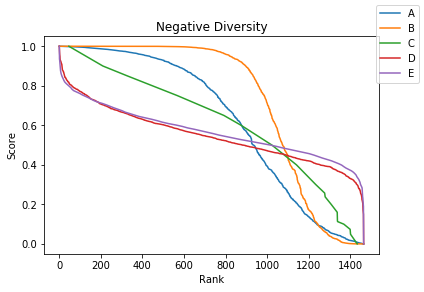

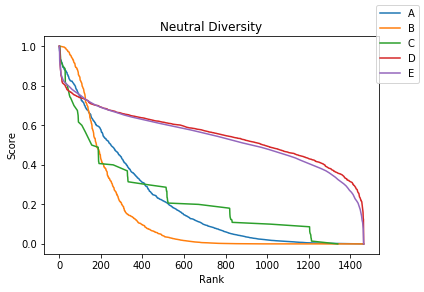

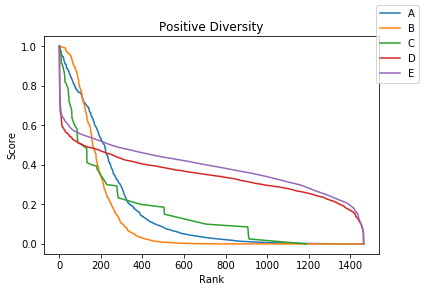

In [14]:
cfaUnigram.RankScoreGraphs()

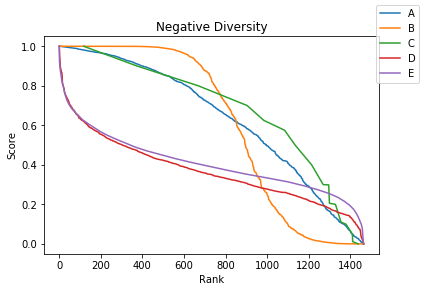

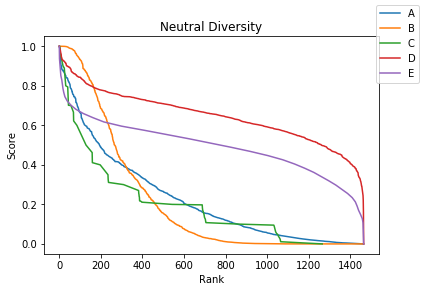

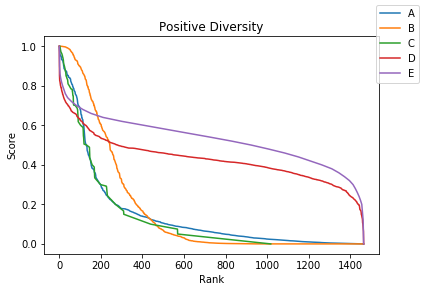

In [15]:
cfaBigram.RankScoreGraphs()

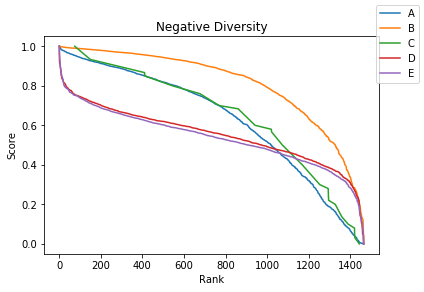

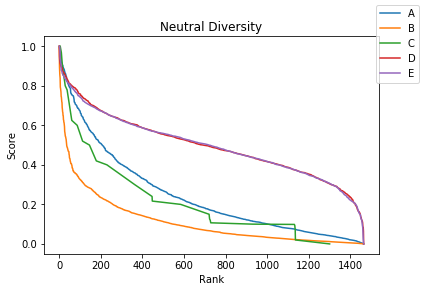

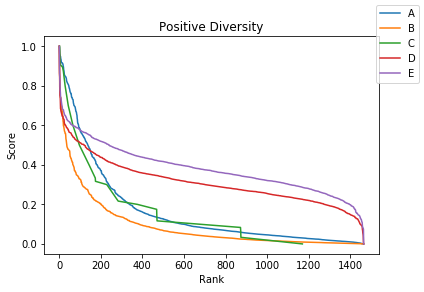

In [16]:
cfaTdidf.RankScoreGraphs()

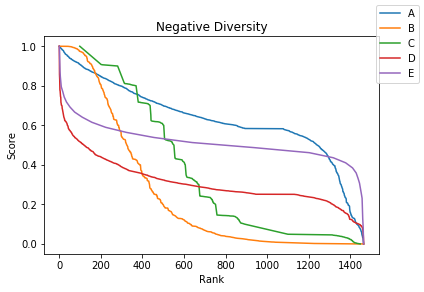

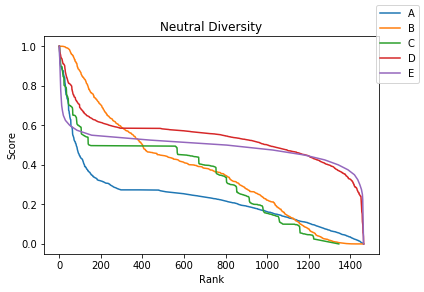

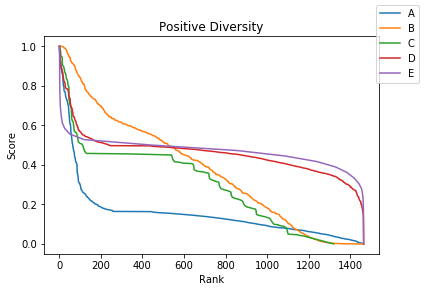

In [17]:
cfaTrigram.RankScoreGraphs()

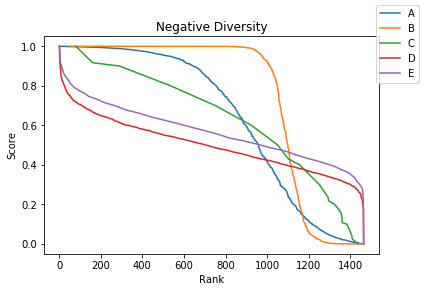

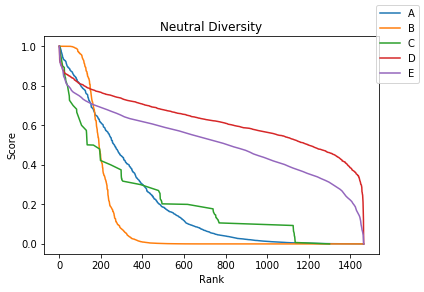

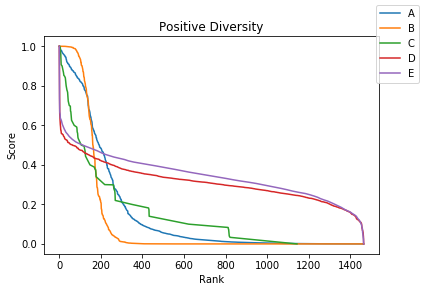

In [18]:
cfaUni_and_Bigram.RankScoreGraphs()

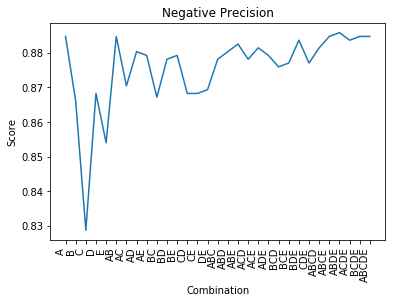

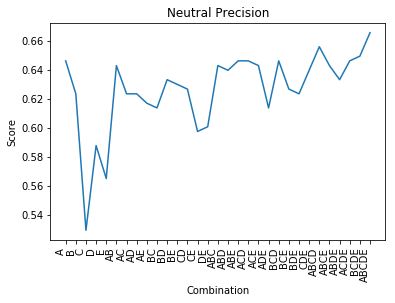

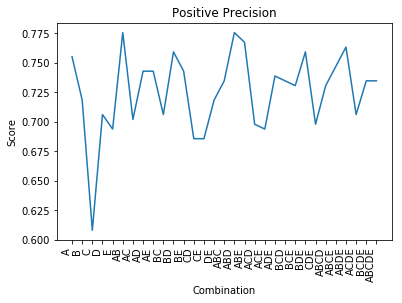

In [19]:
cfaUnigram.PrecisionScoreGraphs()

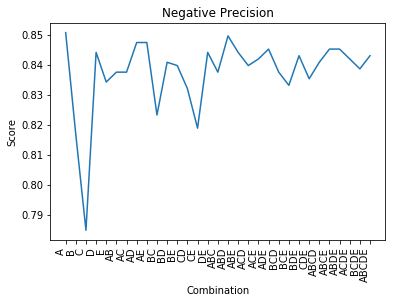

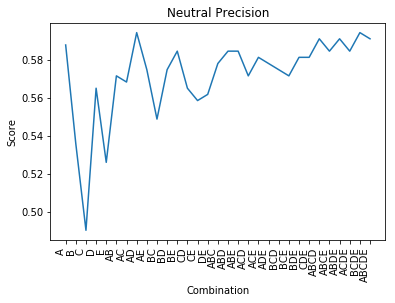

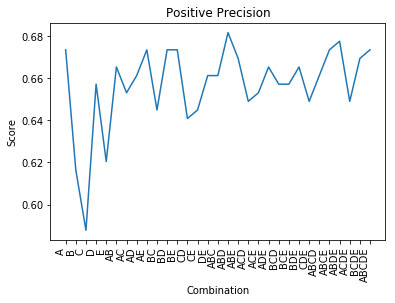

In [20]:
cfaBigram.PrecisionScoreGraphs()

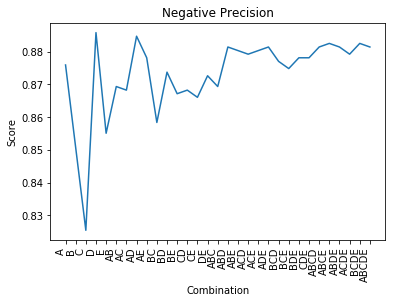

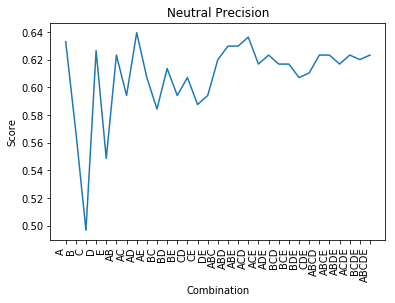

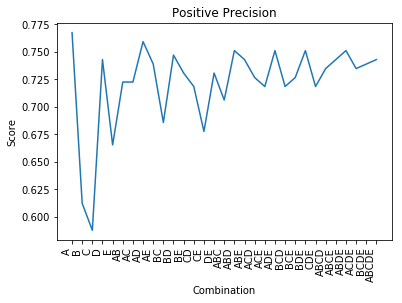

In [21]:
cfaTdidf.PrecisionScoreGraphs()

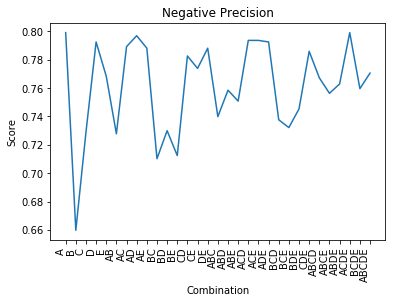

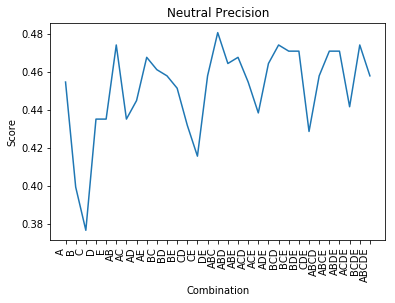

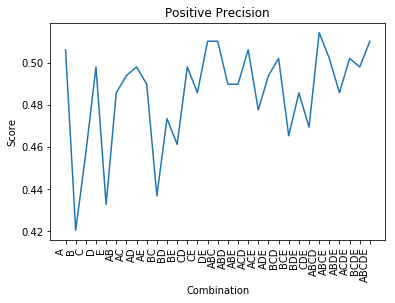

In [22]:
cfaTrigram.PrecisionScoreGraphs()

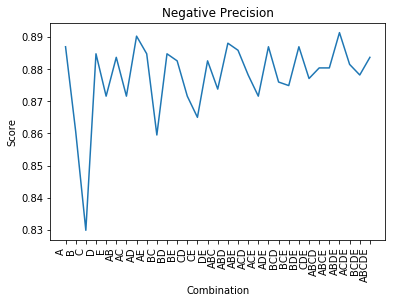

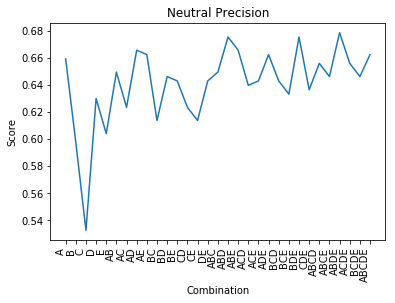

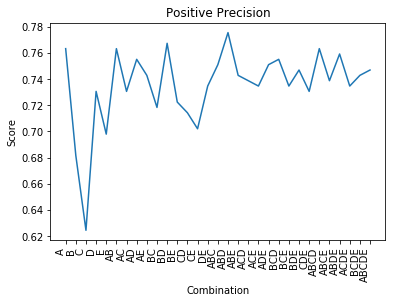

In [23]:
cfaUni_and_Bigram.PrecisionScoreGraphs()